# Installations and Data Load

In [1]:
%%capture

# Installations
!pip install /kaggle/input/pip-install-lifelines/autograd-1.7.0-py3-none-any.whl
!pip install /kaggle/input/pip-install-lifelines/autograd-gamma-0.5.0.tar.gz
!pip install /kaggle/input/pip-install-lifelines/interface_meta-1.3.0-py3-none-any.whl
!pip install /kaggle/input/pip-install-lifelines/formulaic-1.0.2-py3-none-any.whl
!pip install /kaggle/input/pip-install-lifelines/lifelines-0.30.0-py3-none-any.whl

In [2]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [3]:
data_dict = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/data_dictionary.csv')
train_df = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/train.csv')
test_df = pd.read_csv('/kaggle/input/equity-post-HCT-survival-predictions/test.csv')

In [4]:
# make age values more reasonable
for df in [train_df, test_df]:
    df['donor_age'] = round(df['donor_age']*2)/2
    df['age_at_hct'] = round(df['age_at_hct']*2)/2

In [5]:
# some of the 'numeric' cols are more like ordinals so may want to come back to this... (or give the model options?)

cat_vars = [c for c in data_dict[data_dict.type == 'Categorical'].variable if c != 'efs']
num_vars = [c for c in data_dict[data_dict.type == 'Numerical'].variable if c != 'efs_time']

# Target Analysis

In [6]:
from lifelines import KaplanMeierFitter

from matplotlib import pyplot as plt

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

In [7]:
def get_target(df, fitter, time_col='efs_time', event_col='efs'):
    ''' create target val '''
    fitter.fit(df[time_col], df[event_col])
    return fitter.survival_function_at_times(df[time_col]).values

In [8]:
px.histogram(train_df['efs_time'], color=train_df['efs'], opacity=.5).show()

<Axes: xlabel='timeline'>

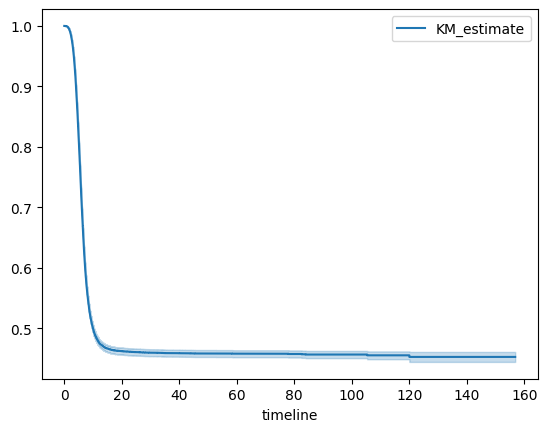

In [9]:
kmf = KaplanMeierFitter()
kmf.fit(train_df['efs_time'], train_df['efs'])
kmf.plot_survival_function()

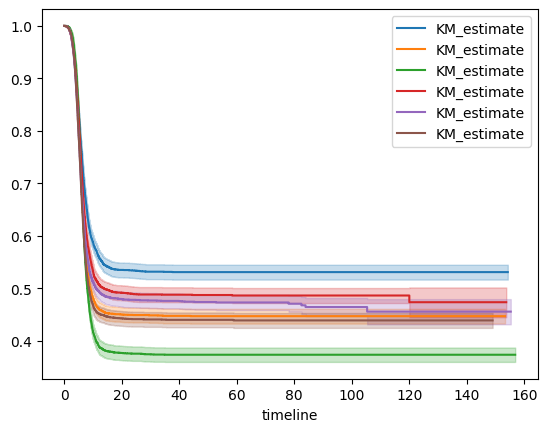

In [10]:
ax = plt.subplot(111)

for race_group in train_df.race_group.unique():
    df = train_df[train_df.race_group==race_group]
    kmf = KaplanMeierFitter()
    kmf.fit(df['efs_time'], df['efs'])
    kmf.plot_survival_function(ax=ax)

In [11]:
train_df['tgt'] = get_target(train_df, KaplanMeierFitter())

# Feature Analysis

## Summary
- Examine blanks by columns and records
- Feature level by observation count by race group
- Feature level by average taget and observation count
- Feature level by average taget by race_group and observation count
- Look for interactions

## Takeaways (not neccessarily shown):
- Features that may add bias to specific race groups
- Feature levels that may need to be forced to combine
- Features that should need to be excluded due to lack of segmentation
- Impact on of upweigting feature levels with low levels
- Features with monotonistic relationship with target

In [12]:
import numpy as np

def record_pct_missing(df:pd.DataFrame, ignore_columns:list[str], essentially_missing_values:list[str]|None=None):
    ''' get pct missing for each record. user can pass values that will be considered missing '''
    essentially_missing_values = [] if essentially_missing_values is None else essentially_missing_values
    tmp_df = df[[c for c in df if c not in ignore_columns]]
    tmp_df = tmp_df.replace(essentially_missing_values, np.nan)
    return (len(tmp_df.columns) - tmp_df.isnull().sum(axis=1))/len(tmp_df.columns)

def column_pct_missing(df:pd.DataFrame, ignore_columns:list[str], essentially_missing_values:list[str]|None=None):
    ''' get pct missing for each record. user can pass values that will be considered missing '''
    essentially_missing_values = [] if essentially_missing_values is None else essentially_missing_values
    tmp_df = df[[c for c in df if c not in ignore_columns]]
    tmp_df = tmp_df.replace(essentially_missing_values, np.nan)
    return tmp_df.isnull().mean().sort_values(ascending=False)


def graph_by_race(df, x:str, tgt_col='tgt', grp='race_group'):
    ''' graph variable count / dist by race'''
    if df[x].dtype == 'O':
        grp_df = df.groupby([x, grp])[[tgt_col]].count().reset_index()
        px.bar(grp_df, x=x, color=grp, y=tgt_col, barmode="group").show()
    else:
        px.histogram(df, x=x, color=grp, barmode="stack").show()

def graph_obs(df, var):
    ''' graph avg taget and obs count by variable value '''
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    grp_df = df.groupby(var)[['tgt']].agg(avg_tgt=('tgt', 'mean'), cnt_obs=('tgt', 'count')).reset_index()
    fig.add_trace(
        go.Scatter(x=grp_df[var], y=grp_df['avg_tgt']),
        secondary_y=False
    )
    fig.add_trace(
        go.Bar(x=grp_df[var], y=grp_df['cnt_obs'], name='Observations', opacity=.25, marker=dict(color = 'yellow')),
        secondary_y=True, 
    )
    fig.show()

def graph_obs_grpd(df, var):
    '''  '''
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    
    df = df.copy(deep=True)
    df[var] = df[var].fillna('Unknown')
    
    grp_df = df.groupby([var, 'race_group'])[['tgt']].agg(avg_tgt=('tgt', 'mean'), cnt_obs=('tgt', 'count')).reset_index()
    for grp in grp_df.race_group.unique():
        grp_df_ = grp_df[grp_df['race_group']==grp]
        fig.add_trace(
            go.Scatter(x=grp_df_[var], y=grp_df_['avg_tgt'], name=grp),
            secondary_y=False
        )
    fig.add_trace(
        go.Bar(x=grp_df[var], y=grp_df['cnt_obs'], name='Observations', opacity=.25, marker=dict(color = 'yellow')),
        secondary_y=True, 
    )
    fig.show()

### Missing Data

In [13]:
# summary stats for records missing, and split by 'event' and not event, and split between within one year

ignore_features = [
    'ID',
    'efs',
    'efs_time',
]

essentially_missing_feature_values = [ # nice name
    'TBD',
    'N/A, F(pre-TED) not submitted',
    'N/A - disease not classifiable',
    'N/A - pediatric' 'TBD cytogenetics',
    'Not tested',
    'Missing disease status',
    'Not done'
]

display(record_pct_missing(train_df, ignore_features, essentially_missing_feature_values).describe())
display(record_pct_missing(train_df[train_df.efs==1], ignore_features, essentially_missing_feature_values).describe())
display(record_pct_missing(train_df[train_df.efs==0], ignore_features, essentially_missing_feature_values).describe())
display(record_pct_missing(train_df[train_df.efs_time<=12], ignore_features, essentially_missing_feature_values).describe())
display(record_pct_missing(train_df[train_df.efs_time>12], ignore_features, essentially_missing_feature_values).describe())

count    28800.000000
mean         0.883278
std          0.116784
min          0.327586
25%          0.844828
50%          0.931034
75%          0.965517
max          1.000000
dtype: float64

count    15532.000000
mean         0.888604
std          0.117818
min          0.344828
25%          0.844828
50%          0.931034
75%          0.965517
max          1.000000
dtype: float64

count    13268.000000
mean         0.877043
std          0.115253
min          0.327586
25%          0.844828
50%          0.913793
75%          0.965517
max          1.000000
dtype: float64

count    15270.000000
mean         0.889158
std          0.117534
min          0.344828
25%          0.844828
50%          0.931034
75%          0.965517
max          1.000000
dtype: float64

count    13530.000000
mean         0.876641
std          0.115576
min          0.327586
25%          0.844828
50%          0.913793
75%          0.965517
max          1.000000
dtype: float64

In [14]:
# columns missing data

column_pct_missing(train_df, ignore_features, essentially_missing_feature_values)

tce_match                 0.659583
mrd_hct                   0.576285
cyto_score_detail         0.455243
tce_div_match             0.395694
tce_imm_match             0.386562
cyto_score                0.328611
hla_high_res_10           0.248715
hla_high_res_8            0.202396
hla_high_res_6            0.183472
conditioning_intensity    0.181389
hla_match_dqb1_high       0.180521
hla_low_res_10            0.175833
hla_match_c_high          0.160417
hla_match_a_high          0.149340
hla_nmdp_6                0.145729
hla_match_dqb1_low        0.145625
hla_match_b_high          0.141944
hla_low_res_8             0.126840
hla_match_drb1_high       0.116389
hla_low_res_6             0.113542
hla_match_c_low           0.097222
cardiac                   0.093368
hla_match_drb1_low        0.091771
peptic_ulcer              0.089757
hla_match_b_low           0.089063
hla_match_a_low           0.082986
rheum_issue               0.080833
arrhythmia                0.080556
pulm_severe         

### Feature Visuals

In [15]:
for v in ['dri_score', 'karnofsky_score', 'obesity']: # just show a few
    print(v)
    graph_by_race(train_df, v)

dri_score


karnofsky_score


obesity


In [16]:
for v in ['year_hct', 'hla_match_a_high','donor_age']: # just show a few
    print(v)
    graph_obs(train_df, v)

year_hct


hla_match_a_high


donor_age


In [17]:
for v in ['comorbidity_score', 'hla_match_b_high', 'age_at_hct']: # just show a few
    print(v)
    graph_obs_grpd(train_df, v)

comorbidity_score


hla_match_b_high


age_at_hct


### Identify Interactions

In [18]:
def heat_map(df, var1, var2):
    ''' heat map of avg target between to vars '''
    grp_df = df.groupby([var1, var2])[['tgt']].mean().reset_index()
    grp_df = grp_df.pivot(index=var1, columns=var2, values='tgt').reset_index(drop=True)
    px.imshow(grp_df, x=grp_df.columns, y=grp_df.index).show()

def grouped_line(df, line_var, grp_var):
    ''' multi-line chart '''
    grp_df = df.groupby([line_var, grp_var])[['tgt']].agg(avg_tgt=('tgt', 'mean'), cnt_tgt=('tgt', 'count')).reset_index().sort_values(by=line_var)
    px.line(grp_df, x=line_var, y='avg_tgt', color=grp_var, hover_data=['avg_tgt', 'cnt_tgt']).show()

In [19]:
heat_map(train_df, 'dri_score', 'hla_match_b_high')

In [20]:
grouped_line(train_df,'dri_score', 'hla_match_b_high')

# Cluster Analysis
- Clean data to remove missing values
- Group variables (through experimentation found this yielded better results than filling as 'Unknown')
- Slim feature selection (yielded better results)
- Loop number of clusters through loop that creates silhouette analysis, and box plot of target distribution of each cluster

In [21]:
def create_yesno_group_map(var):
    ''' create tuple for yes,no group var for variables with Yes, No, Not done levels '''
    return (
        var,
        'yes,no',
        {'No':'No', 'Not done':'No', 'Yes':'Yes'},
        'No'
    )

def get_ordinal_map(df, var, tgt='tgt'):
    ''' create ordinal dict map where each group rel to target monotonistic increasing  '''
    grp_df = df.groupby(var)[[tgt]].mean().reset_index().sort_values(by=tgt)
    series = grp_df[var]
    return {v:i+1 for i,v in enumerate(series)}



import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from sklearn.cluster import KMeans #, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score

def sklearn_silhouette_analysis(cluster_obj, X, y, range_n_clusters:list[int], sample_wgt=None, **kwargs):
    '''
    Leveraged scihit-learn silhoutte analysis:
    
    Authors: The scikit-learn developers
    SPDX-License-Identifier: BSD-3-Clause 

    https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py
    '''
    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)
    
        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    
        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = cluster_obj(n_clusters, **kwargs)
        cluster_labels = clusterer.fit_predict(X, sample_wgt)
    
        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print(
            "For n_clusters =",
            n_clusters,
            "The average silhouette_score is :",
            silhouette_avg,
        )
    
        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)
    
        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    
            ith_cluster_silhouette_values.sort()
    
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7,
            )
    
            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    
            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples
    
        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    
        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
        # 2nd Plot showing groups and avg response
        df = pd.DataFrame({
            'tgt':y,
            'labels':cluster_labels
        })
        series = []
        for label in df.labels.unique():
            one_label_df = df[df.labels==label]
            series.append(one_label_df.tgt)
        ax2.boxplot(series)

        # print(stats.kruskal(*series))
        # print(stats.f_oneway(*series))
        print(pairwise_tukeyhsd(endog=df['tgt'], groups=df['labels'], alpha=0.05))
        # This test compares all possible pairs of means to identify which pairs are significantly different.

        print()
        print()
    
    plt.show()

In [22]:
# group to make the clustering more effective

cat_var_group_maps = ( # (var, map, fill_val)
    (
        'dri_score',
        'high,other',
        {
            'High':'High', 
            'High - TED AML case <missing cytogenetics':'High', 
            'Very high':'High'
        }, 
        'Other'
    ),
    (
        'cyto_score',
        'poor,other',
        {
            'Poor':'Poor'
        },
        'Other'
    ),
    (
        'cyto_score_detail',
        'favorable,intermediate,poor',
        {
            'Favorable':'Favorable', 
            'Poor':'Poor',
        }, 
        'Intermediate'
    ),
    (
        'conditioning_intensity',
        'mac,nma,ric,other',
        {
            'MAC':'MAC',
            'NMA':'NMA',
            'RIC':'RIC'
        },
        'Other'
    ),
    create_yesno_group_map('psych_disturb'),
    create_yesno_group_map('diabetes'),
    create_yesno_group_map('arrhythmia'),
    create_yesno_group_map('pulm_severe'),
    create_yesno_group_map('hepatic_severe'),
    create_yesno_group_map('prior_tumor'),
)

for var, grp_name, map_, fill_val in cat_var_group_maps:
    train_df[f'{var}_grp_{grp_name}'] = train_df[var].map(map_).fillna(fill_val)

In [23]:
grp_vars = [c for c in train_df if '_grp_' in c]

get_ordinal_map(train_df, 'dri_score_grp_high,other')

# create ord cols
for grp_var in grp_vars:
    ordinal_map = get_ordinal_map(train_df, grp_var)
    train_df[f'ord_{grp_var}'] = train_df[grp_var].map(ordinal_map)

In [24]:
vars_for_clustering = [
    'tbi_status',
    'prim_disease_hct',
    'age_at_hct',
    'dri_score_grp_high,other',
    'cyto_score_grp_poor,other',
    'cyto_score_detail_grp_favorable,intermediate,poor',
    'conditioning_intensity_grp_mac,nma,ric,other',
    'psych_disturb_grp_yes,no',
    'diabetes_grp_yes,no',
    'arrhythmia_grp_yes,no',
    'pulm_severe_grp_yes,no',
    'hepatic_severe_grp_yes,no',
    'prior_tumor_grp_yes,no'
]

In [25]:
num_vars_for_clustering = [c for c in train_df[vars_for_clustering] if c in num_vars]
cat_vars_for_clustering = [c for c in train_df[vars_for_clustering] if c in cat_vars]
cat_vars_for_clustering +=grp_vars

In [26]:
cat_dummy_data = pd.get_dummies(train_df[cat_vars_for_clustering], columns=cat_vars_for_clustering)

num_data = train_df[num_vars_for_clustering].copy()
# theres a way to do this one line.. too lazy to find...
for var in num_vars_for_clustering:
    num_data[var] = num_data[var].fillna(num_data[var].mean())
    
data = pd.concat([num_data, cat_dummy_data], axis=1)

For n_clusters = 2 The average silhouette_score is : 0.6267323213551421
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
     0      1  -0.0458   0.0 -0.0502 -0.0415   True
---------------------------------------------------


For n_clusters = 3 The average silhouette_score is : 0.6142220372675747
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
     0      1   0.0613   0.0  0.0553  0.0673   True
     0      2   0.0312   0.0  0.0248  0.0376   True
     1      2  -0.0301   0.0 -0.0358 -0.0244   True
---------------------------------------------------


For n_clusters = 4 The average silhouette_score is : 0.5782811791600029
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
--------------------------------------------------

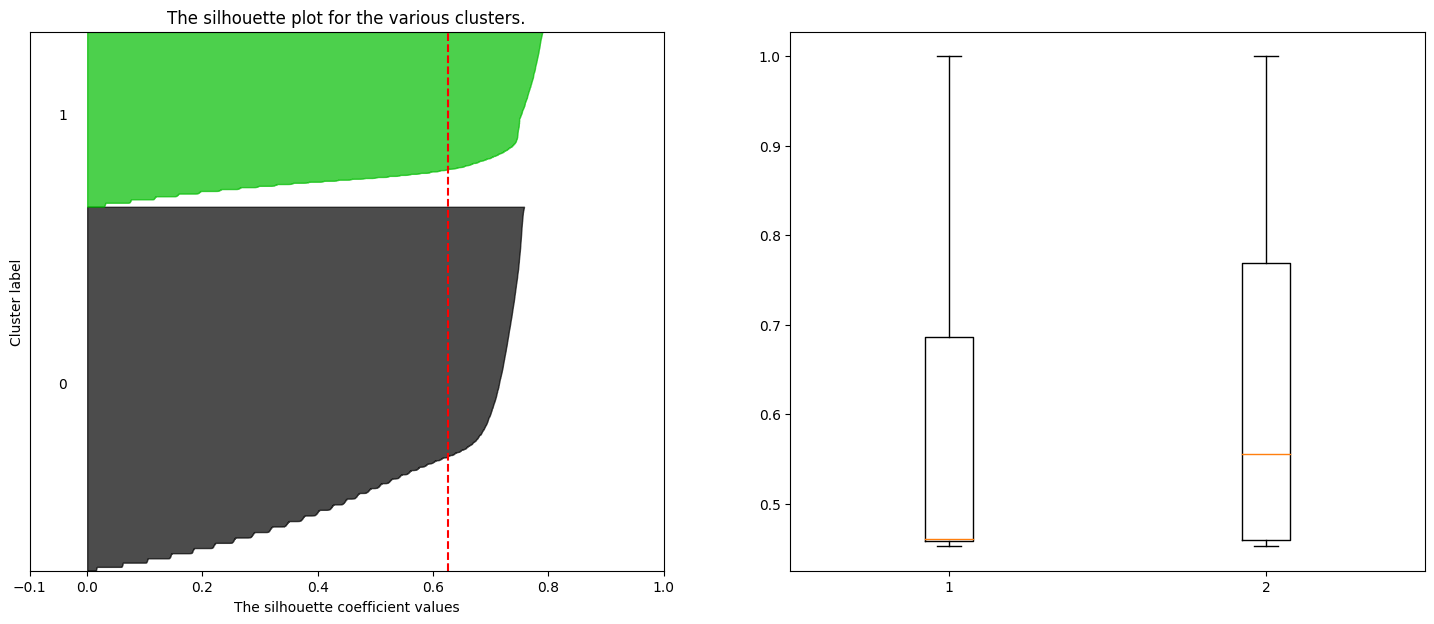

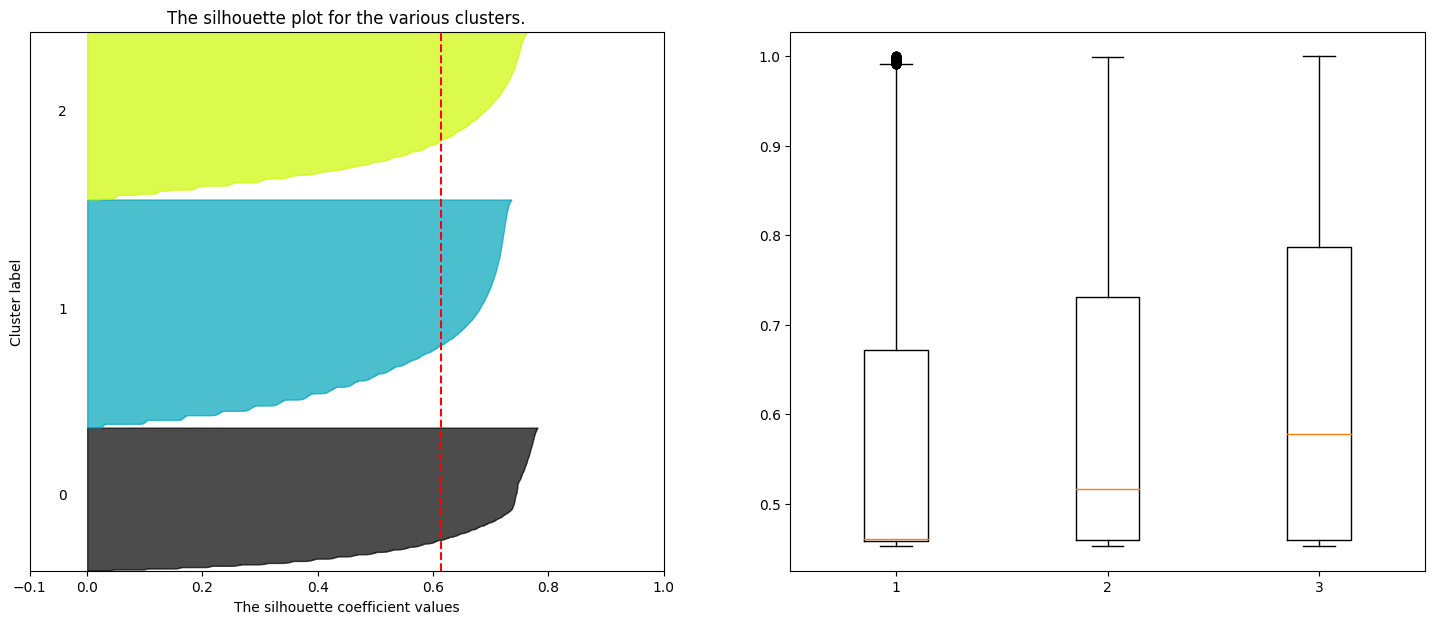

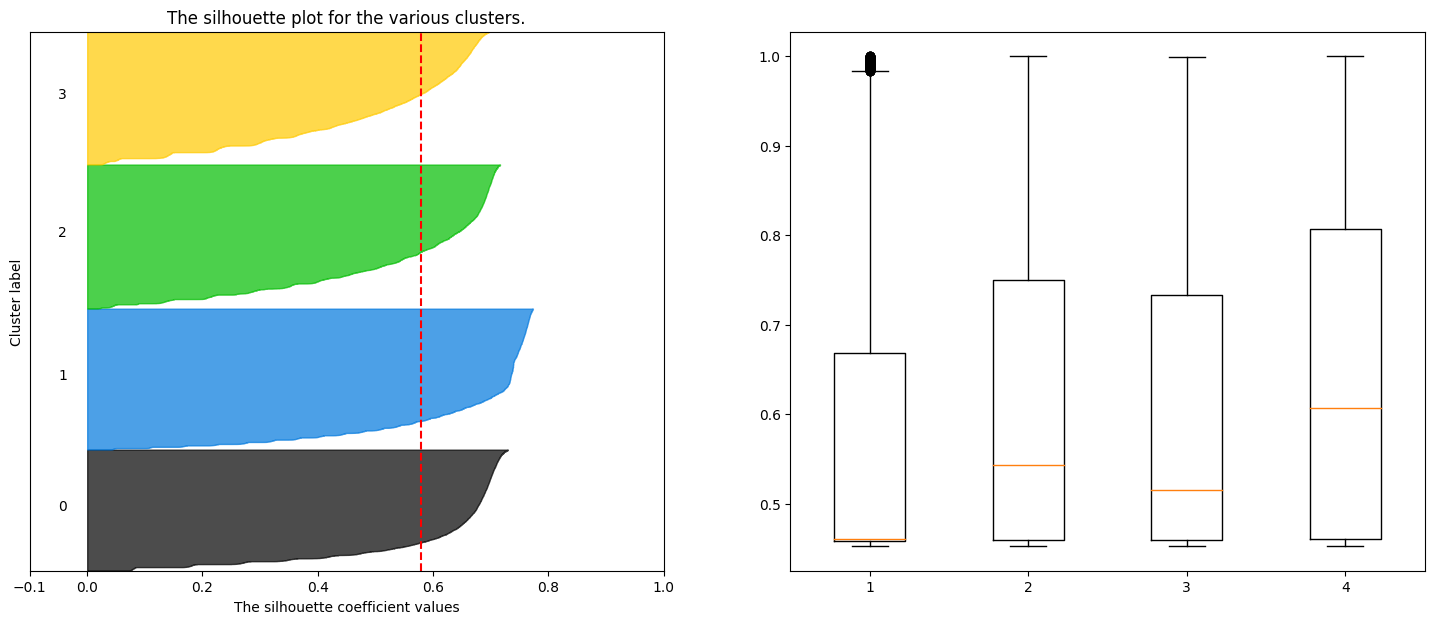

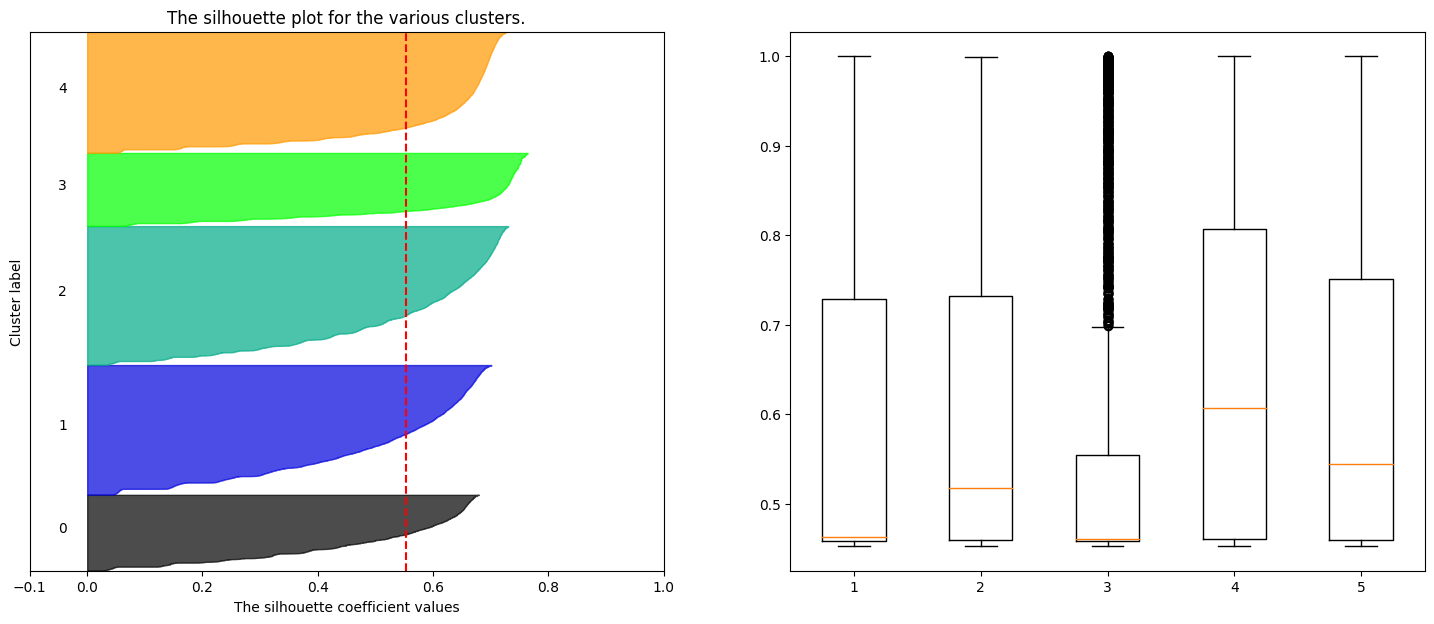

In [27]:
range_n_clusters = [2, 3, 4, 5]
sklearn_silhouette_analysis(KMeans, data, train_df['tgt'], range_n_clusters, random_state=42)

# sklearn_silhouette_analysis(DBSCAN, data, train_raw['tgt'], range_n_clusters) # too many -1 values
# sklearn_silhouette_analysis(AgglomerativeClustering, data, train_raw['tgt'], range_n_clusters) # no significant difference to KMeans